# Sali-Cache Results Visualization
This notebook compares the baseline sliding-window cache against the optimized Sali-Cache pipeline.
Run the baseline and optimized experiments first; they should save JSON results to `results/baseline.json` and `results/salicache.json`.

Baseline loaded: True
Sali-Cache loaded: True


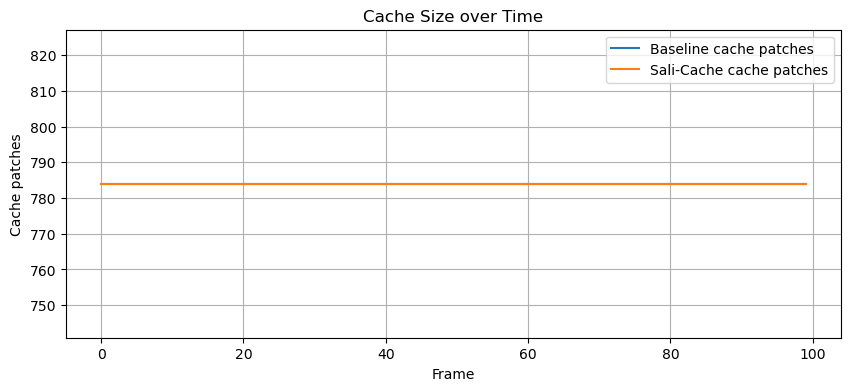

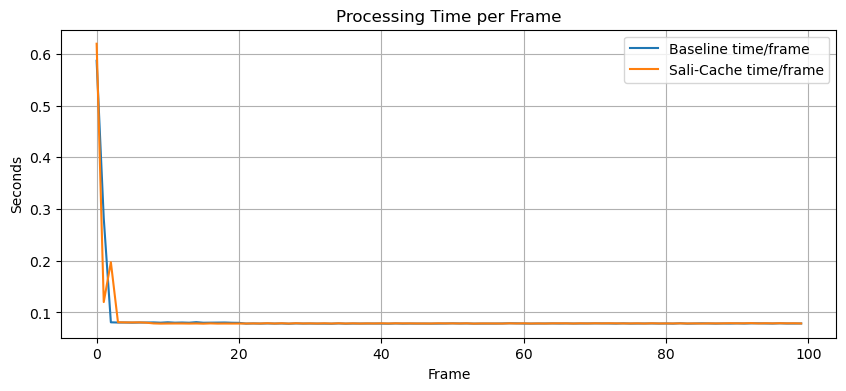

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

def load_results(path):
    if not os.path.exists(path):
        return None
    with open(path, 'r') as f:
        return json.load(f).get('results', [])

baseline = load_results('results/baseline.json')
salicache = load_results('results/salicache.json')

print('Baseline loaded:', bool(baseline))
print('Sali-Cache loaded:', bool(salicache))

plt.figure(figsize=(10,4))
if baseline is not None:
    frames = [r['frame'] for r in baseline]
    patches = [r['cache_patches'] for r in baseline]
    times = [r['time_s'] for r in baseline]
    plt.plot(frames, patches, label='Baseline cache patches')
if salicache is not None:
    frames_s = [r['frame'] for r in salicache]
    patches_s = [r['cache_patches'] for r in salicache]
    times_s = [r.get('time_s', None) for r in salicache]
    plt.plot(frames_s, patches_s, label='Sali-Cache cache patches')

plt.xlabel('Frame')
plt.ylabel('Cache patches')
plt.legend()
plt.title('Cache Size over Time')
plt.grid(True)
plt.show()

# Plot processing time per frame if available
plt.figure(figsize=(10,4))
if baseline is not None:
    plt.plot(frames, times, label='Baseline time/frame')
if salicache is not None and any(times_s):
    plt.plot(frames_s, times_s, label='Sali-Cache time/frame')
plt.xlabel('Frame')
plt.ylabel('Seconds')
plt.legend()
plt.title('Processing Time per Frame')
plt.grid(True)
plt.show()